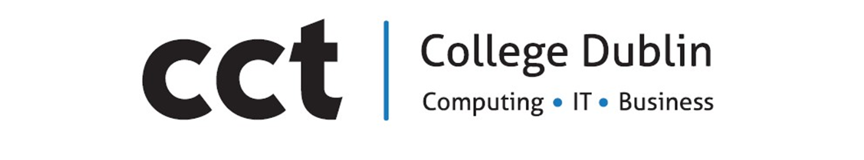

<h1 align="center">Subject: Machine Learning</h1>
<h2 align="center">Lecturer: David McQuaid</h2>
<h3 align="center">Caio Machado de Oliveira</h3>
<h4 align="center">ID: 2020351</h4>
<h5 align="center">April/2024</h5>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [2]:
data = pd.read_csv("crime-per-county.csv")

data.head()

,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1.0
1,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0.0
2,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0.0
3,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0.0
4,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166992 entries, 0 to 166991
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATISTIC Label  166992 non-null  object 
 1   Quarter          166992 non-null  object 
 2   Garda Division   166992 non-null  object 
 3   Type of Offence  166992 non-null  object 
 4   UNIT             166992 non-null  object 
 5   VALUE            166383 non-null  float64
dtypes: float64(1), object(5)
memory usage: 7.6+ MB


In [4]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)


In [5]:
data['VALUE'] = data['VALUE'].fillna(0)


In [6]:
data['VALUE'] = data['VALUE'].astype('int64')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166992 entries, 0 to 166991
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Quarter          166992 non-null  object
 1   Garda Division   166992 non-null  object
 2   Type of Offence  166992 non-null  object
 3   VALUE            166992 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.1+ MB


In [8]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)



In [9]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166992 entries, 0 to 166991
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Quarter          166992 non-null  object
 1   Garda Division   166992 non-null  object
 2   Type of Offence  166992 non-null  object
 3   VALUE            166992 non-null  int64 
 4   Date             166992 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.4+ MB


In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [12]:
data.drop(columns =['Quarter'], inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166992 entries, 2003-01-01 to 2023-10-01
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Garda Division   166992 non-null  object
 1   Type of Offence  166992 non-null  object
 2   VALUE            166992 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.1+ MB


In [14]:
data = data[data['VALUE'] != 0]

In [15]:
data.info() 
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120808 entries, 2003-01-01 to 2023-10-01
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Garda Division   120808 non-null  object
 1   Type of Offence  120808 non-null  object
 2   VALUE            120808 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


,VALUE
count,120808.000000
mean,81.256763
std,170.400775
min,1.000000
25%,2.000000
50%,16.000000
75%,86.000000
max,2541.000000


In [16]:
data.rename(columns = {'Type of Offence': 'Offence', 'VALUE': 'Crime'}, inplace=True)

In [17]:
data.head()

,Garda Division,Offence,Crime
Date,,,
2003-01-01,Cavan/Monaghan Garda Division,Homicide offences,1
2003-01-01,Cavan/Monaghan Garda Division,Dangerous driving leading to death,1
2003-01-01,Cavan/Monaghan Garda Division,Sexual offences,23
2003-01-01,Cavan/Monaghan Garda Division,Rape and sexual assault,23
2003-01-01,Cavan/Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",128


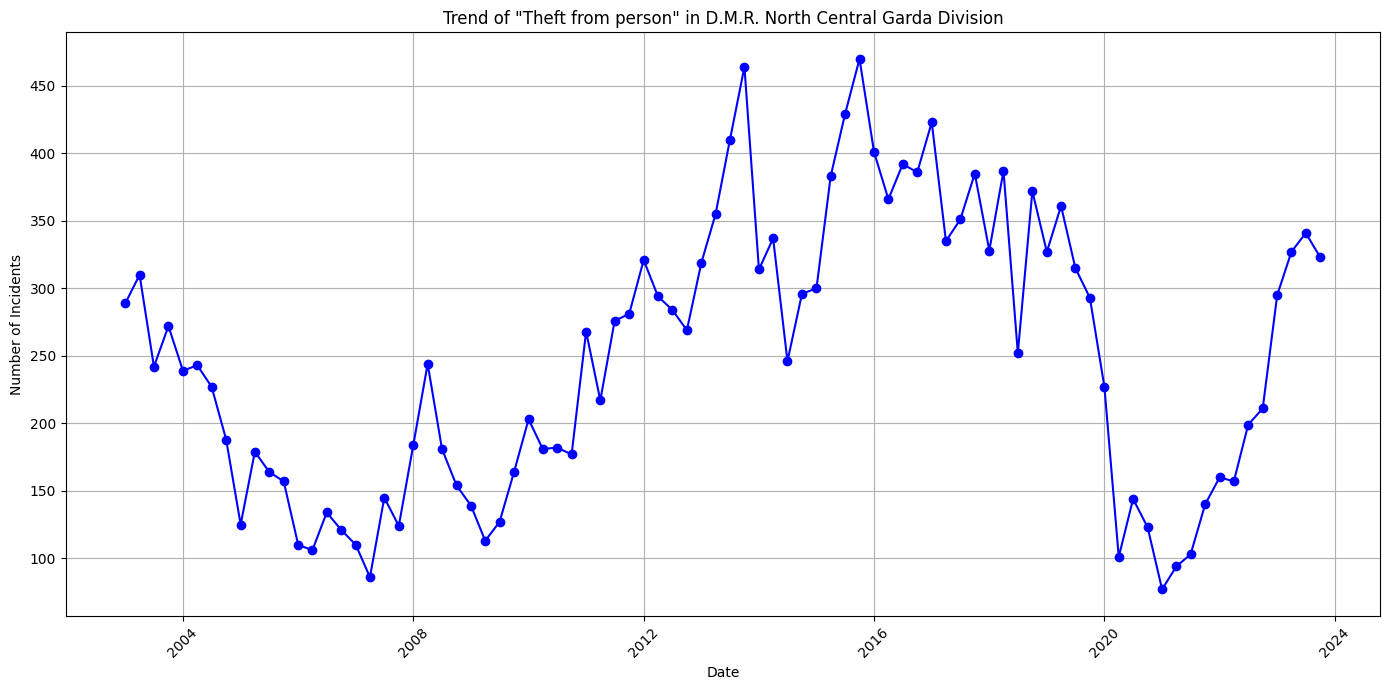

In [18]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Offence'] == 'Theft from person') & 
    (data['Garda Division'] == 'D.M.R. North Central Garda Division')
]

# Pivot to get a time series of "Theft from person" crimes for D.M.R. North Central Garda Division
theft_from_person_time_series = theft_from_person_data.pivot_table(values='Crime', index='Date', aggfunc='sum')

# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_time_series.index, theft_from_person_time_series['Crime'], marker='o', linestyle='-', color='b')
plt.title('Trend of "Theft from person" in D.M.R. North Central Garda Division')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


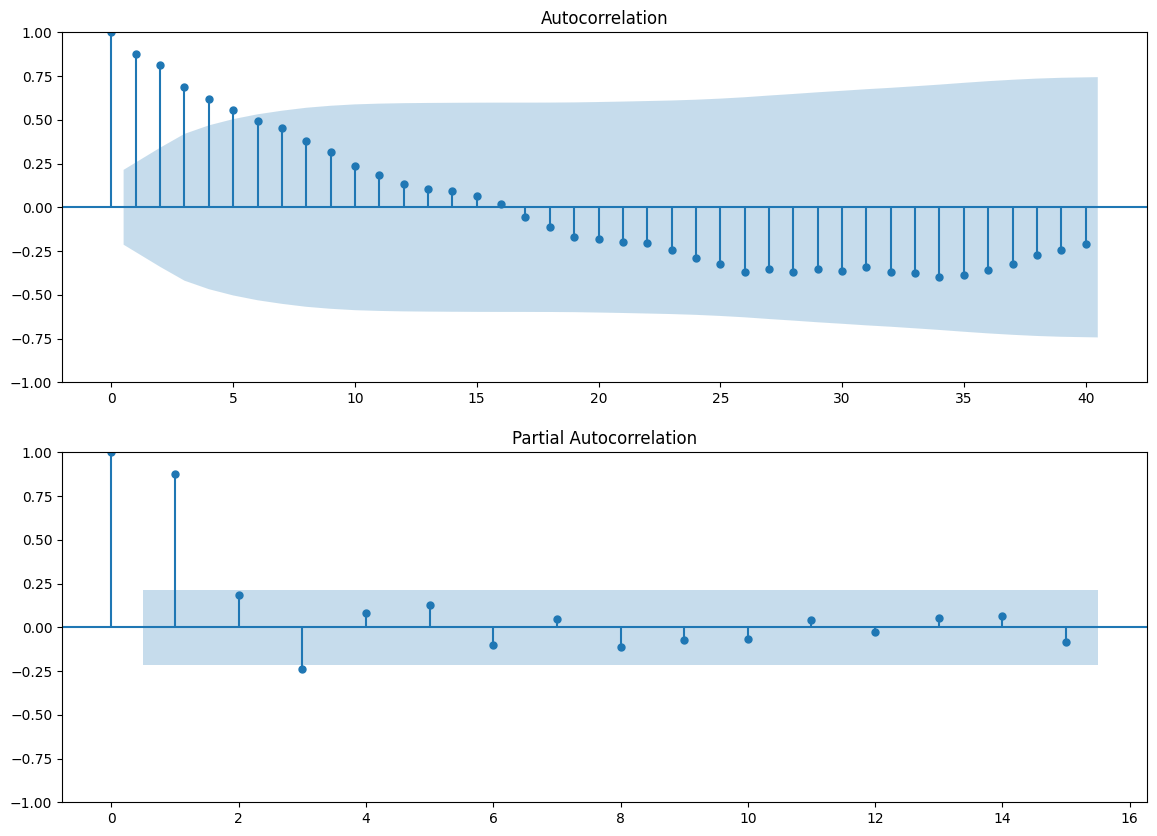

((-2.1574690536953205,
  0.22204207743186055,
  2,
  81,
  {'1%': -3.5137900174243235,
   '5%': -2.8979433868293945,
   '10%': -2.5861907285474777},
  757.4328813516775),
 <Figure size 1500x600 with 4 Axes>)

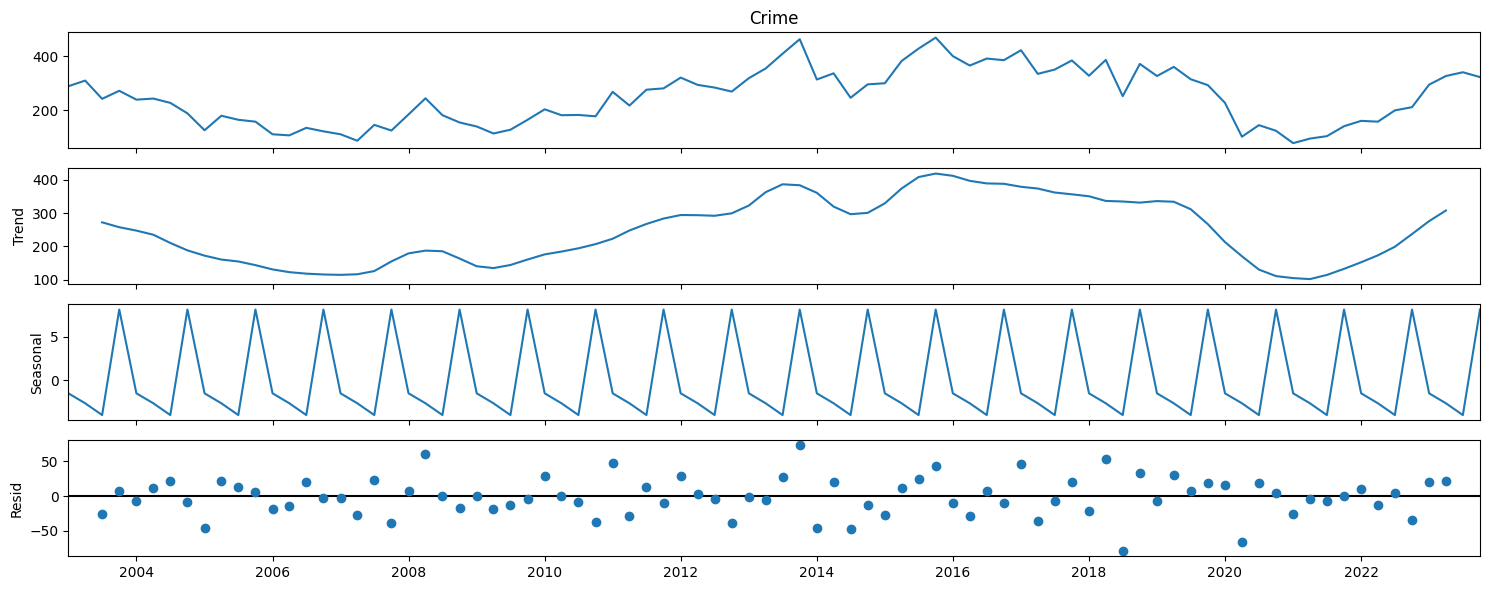

In [19]:
# Seasonal Decomposition
decomposition = seasonal_decompose(theft_from_person_time_series['Crime'], model='additive', period=4)

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(theft_from_person_time_series['Crime'], lags=40, ax=ax1)
plot_pacf(theft_from_person_time_series['Crime'], lags=15, ax=ax2)
plt.show()

# Results
adf_test, decomposition.plot()


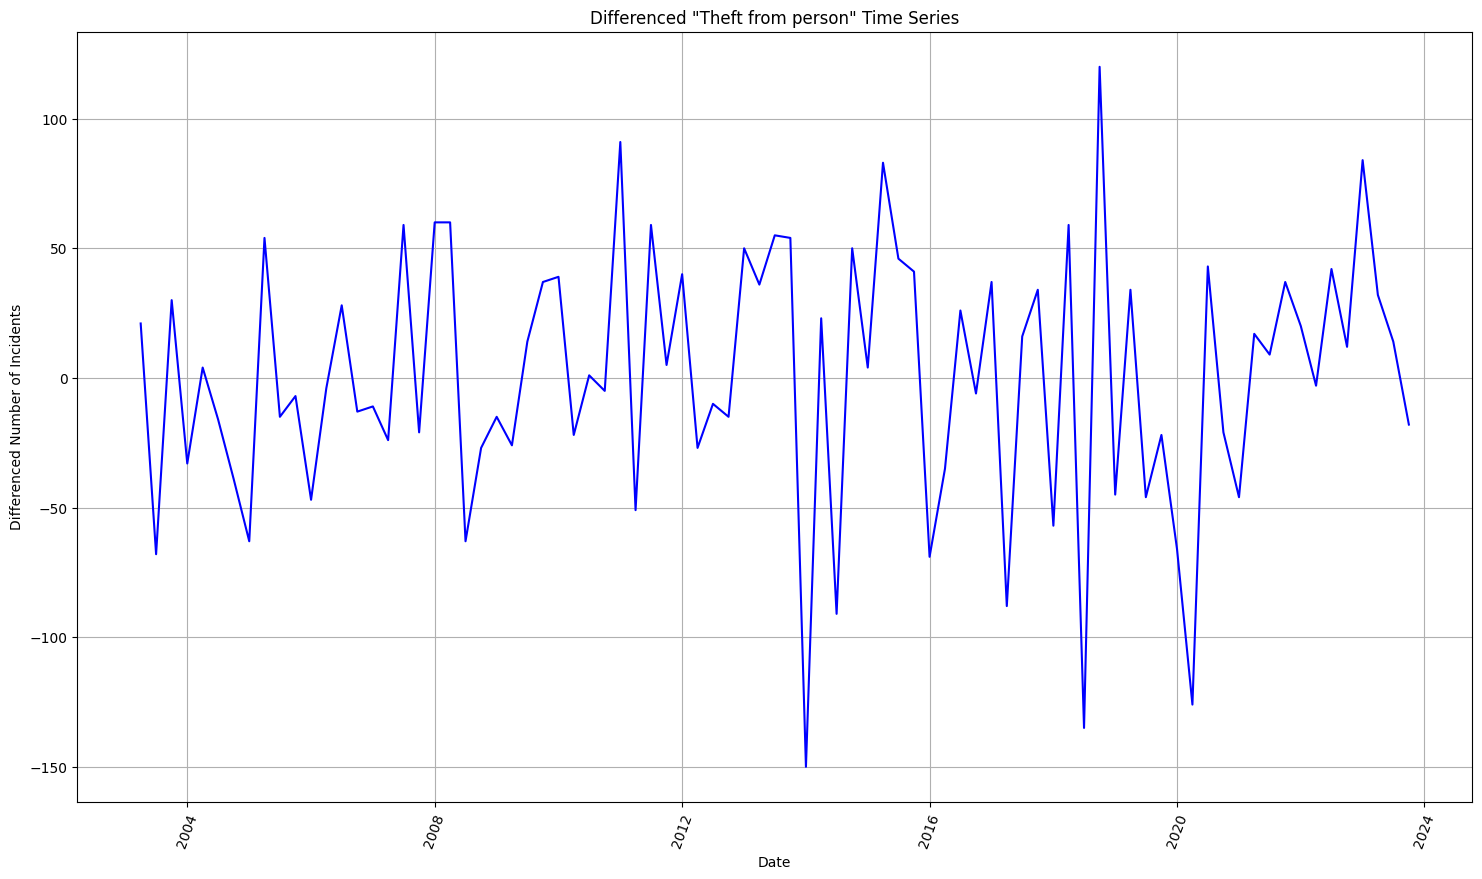

In [20]:
# Differencing the data to make it stationary
theft_from_person_diff = theft_from_person_time_series['Crime'].diff().dropna()


# Plotting the differenced data
plt.figure(figsize=(18, 10))
plt.plot(theft_from_person_diff, color='blue')
plt.title('Differenced "Theft from person" Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Number of Incidents')
plt.grid(True)
plt.xticks(rotation=70)
plt.show()


In [21]:
def ad_test(theft_from_person_diff):
    datasettest = adfuller(theft_from_person_diff, autolag = 'AIC')
    print("1. ADF : ", datasettest[0])
    print("2. P-value : ", datasettest[1])
    print("3. Num of Lags: ", datasettest[2])
    print("4. Num of observations used for ADF regression and critical values calculation : ", datasettest[3])
    print("5. Critical values : ")
    for key, val in datasettest[4].items():
        print("\t", key, ": ", val)

ad_test(theft_from_person_diff)

1. ADF :  -5.677389627529372
2. P-value :  8.641840469916911e-07
3. Num of Lags:  1
4. Num of observations used for ADF regression and critical values calculation :  81
5. Critical values : 
	 1% :  -3.5137900174243235
	 5% :  -2.8979433868293945
	 10% :  -2.5861907285474777


ADF Statistic: -5.677389627529372

This is the test statistic for the ADF test. The more negative this statistic, the stronger the rejection of the null hypothesis that there is a unit root (i.e., the series is non-stationary).
p-value: 8.641840469916911e-07

This is the probability of observing the data if the null hypothesis is true. A very low p-value (typically < 0.05) means you can reject the null hypothesis of non-stationarity. In your case, the p-value is significantly low, indicating that the time series does not have a unit root and is stationary.
Lags Used: 1

This indicates the number of lags used in the regression when performing the ADF test.
Number of Observations Used: 81

This tells you how many observations were used in the ADF test after adjusting for lags.
Critical Values:

These values define the threshold at which the ADF test statistic should be compared to conclude whether the time series is stationary.
For a confidence level of 99%, 95%, and 90%, the critical values are -3.51, -2.90, and -2.59, respectively.
Maximized Information Criterion if autolag is not None: 75ity of the series.

In [30]:
def ad_test(theft_from_person_data):
    datasettest = adfuller(theft_from_person_data, autolag = 'AIC')
    print("1. ADF : ", datasettest[0])
    print("2. P-value : ", datasettest[1])
    print("3. Num of Lags: ", datasettest[2])
    print("4. Num of observations used for ADF regression and critical values calculation : ", datasettest[3])
    print("5. Critical values : ")
    for key, val in datasettest[4].items():
        print("\t", key, ": ", val)

ad_test(theft_from_person_data)

1. ADF :  -2.1574690536953205
2. P-value :  0.22204207743186055
3. Num of Lags:  2
4. Num of observations used for ADF regression and critical values calculation :  81
5. Critical values : 
	 1% :  -3.5137900174243235
	 5% :  -2.8979433868293945
	 10% :  -2.5861907285474777


In [22]:
theft_from_person_data.drop(columns =['Garda Division', 'Offence'], inplace=True)
#data.drop(columns =['Garda Division', 'Offence'], inplace=True)

C:\Users\35383\AppData\Local\Temp\ipykernel_2952\1252237979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theft_from_person_data.drop(columns =['Garda Division', 'Offence'], inplace=True)


C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-

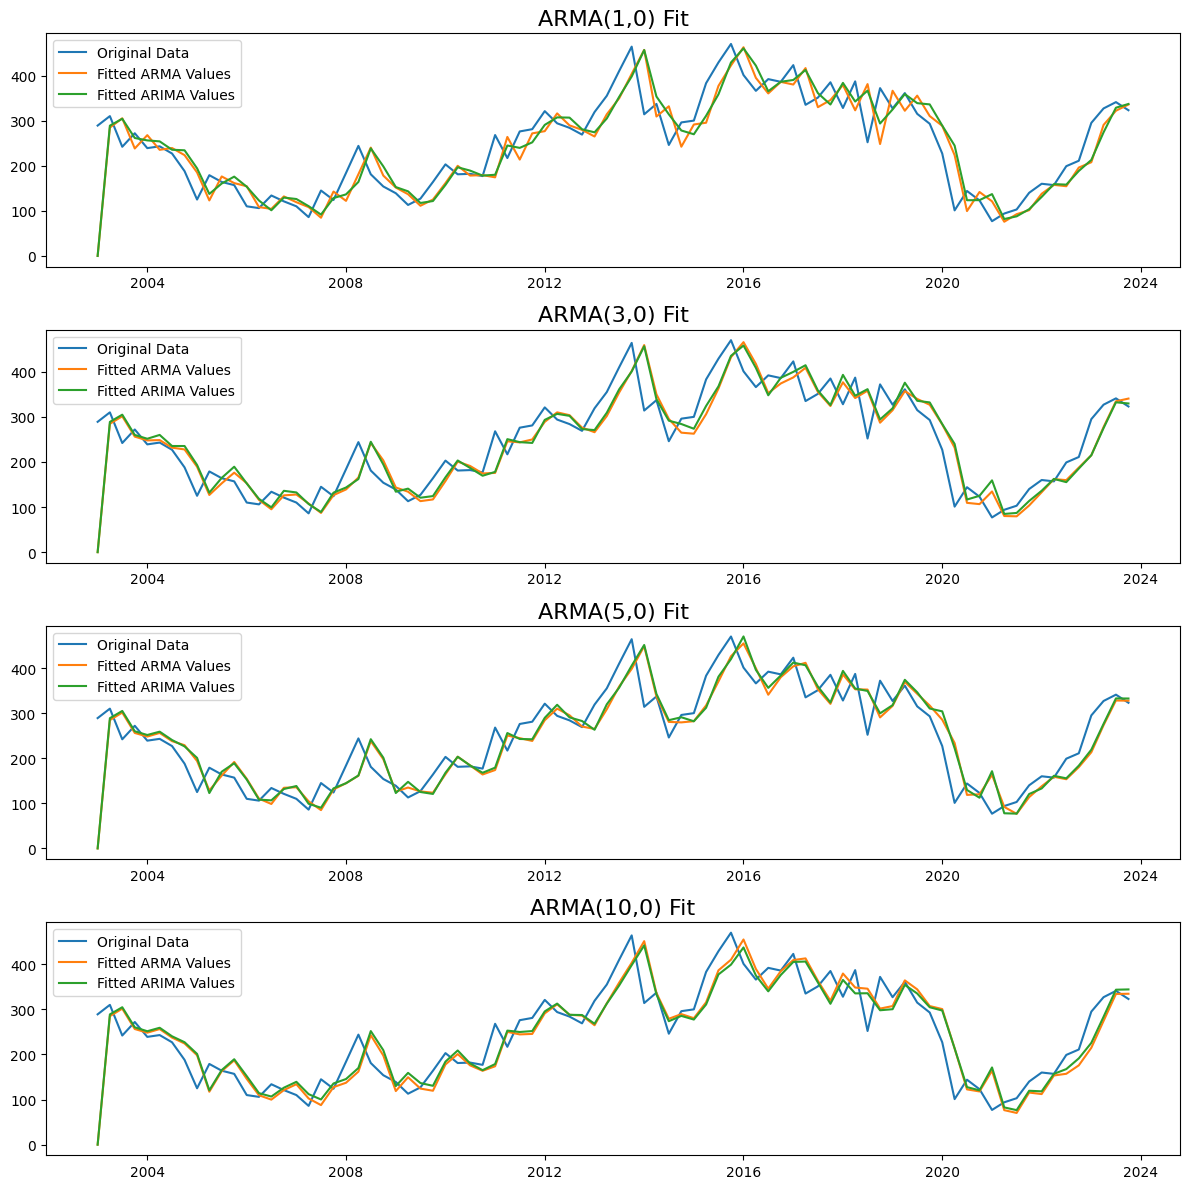

In [31]:
plt.figure(figsize=(12, 12))
ar_orders = [1, 3, 5, 10]
fitted_arma_model_dict = {}
fitted_arima_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    # Create AR(p) model using SARIMAX as an ARMA(p,0) model
    arma_model = SARIMAX(theft_from_person_data, order=(ar_order, 0, 0), seasonal_order=(0, 0, 0, 0)) #ARMA MODEL
    arima_model = SARIMAX(theft_from_person_data, order=(ar_order, 1, 1)) # ARIMA MODEL
    arma_model_fit = arma_model.fit(disp=False)  # Set disp=False to suppress convergence output
    arima_model_fit = arima_model.fit(disp=False)  # Set disp=False to suppress convergence output
    fitted_arma_model_dict[ar_order] = arma_model_fit
    fitted_arima_model_dict[ar_order] = arima_model_fit
    # Plotting
    plt.subplot(4, 1, idx + 1)
    plt.plot(theft_from_person_data, label='Original Data')
    plt.plot(arma_model_fit.fittedvalues, label='Fitted ARMA Values')
    plt.plot(arima_model_fit.fittedvalues, label='Fitted ARIMA Values')
    plt.title(f'ARMA({ar_order},0) Fit', fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

#### The SARIMAX model can function as an ARMA model by setting the seasonal order to zero and ignoring the integrated (I) component. This class provides the flexibility to model AR, MA, ARMA, ARIMA, and seasonal variations thereof.



C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\35383\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-

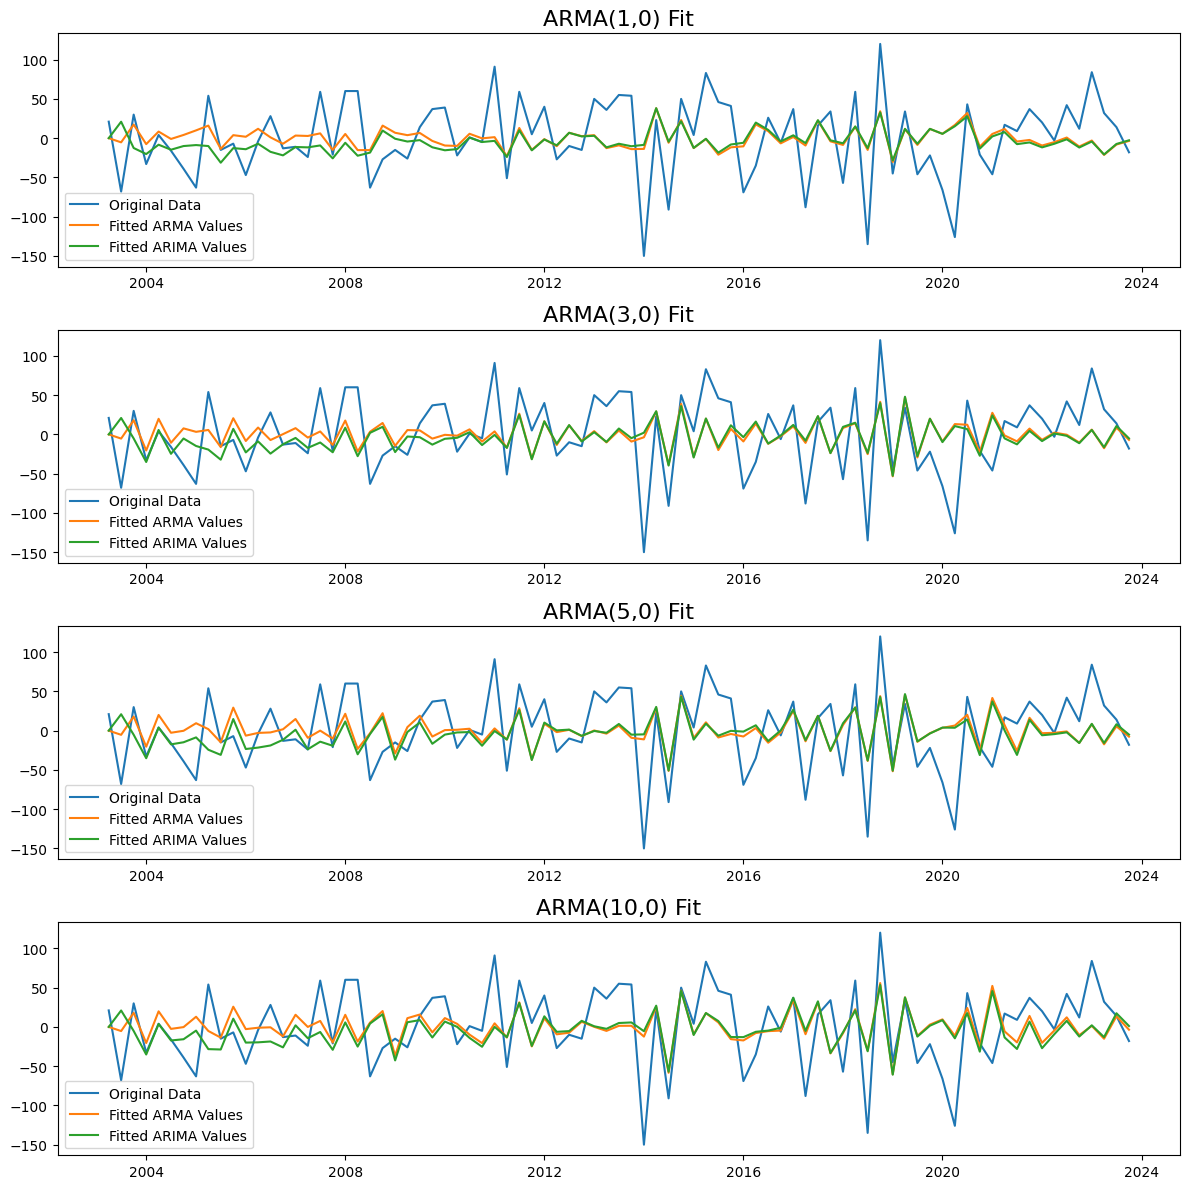

In [29]:
plt.figure(figsize=(12, 12))
ar_orders = [1, 3, 5, 10]
fitted_arma_model_dict = {}
fitted_arima_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    # Create AR(p) model using SARIMAX as an ARMA(p,0) model
    arma_model = SARIMAX(theft_from_person_diff, order=(ar_order, 0, 0), seasonal_order=(0, 0, 0, 0)) #ARMA MODEL
    arima_model = SARIMAX(theft_from_person_diff, order=(ar_order, 1, 1)) # ARIMA MODEL
    arma_model_fit = arma_model.fit(disp=False)  # Set disp=False to suppress convergence output
    arima_model_fit = arima_model.fit(disp=False)  # Set disp=False to suppress convergence output
    fitted_arma_model_dict[ar_order] = arma_model_fit
    fitted_arima_model_dict[ar_order] = arima_model_fit
    # Plotting
    plt.subplot(4, 1, idx + 1)
    plt.plot(theft_from_person_diff, label='Original Data')
    plt.plot(arma_model_fit.fittedvalues, label='Fitted ARMA Values')
    plt.plot(arima_model_fit.fittedvalues, label='Fitted ARIMA Values')
    plt.title(f'ARMA({ar_order},0) Fit', fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

In [38]:
#AIC ARMA
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_arma_model_dict[ar_order].aic))
  
    

AIC for AR(1): 903.954433069575
AIC for AR(3): 898.7179888180164
AIC for AR(5): 899.7791554403059
AIC for AR(10): 907.5453269956818


In [37]:
#AIC ARIMA
for ar_order in ar_orders:
    print('AIC for AR2(%s): %s' %(ar_order, fitted_arima_model_dict[ar_order].aic))


AIC for AR2(1): 883.7627343833751
AIC for AR2(3): 884.9403399972654
AIC for AR2(5): 886.6063053972073
AIC for AR2(10): 892.2715527322146


In [39]:
#BIC ARMA
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_arma_model_dict[ar_order].bic))
  

AIC for AR(1): 908.8160666672616
AIC for AR(3): 908.4412560133896
AIC for AR(5): 914.3640562333658
AIC for AR(10): 934.2843117829582


In [40]:
#BIC ARIMA
for ar_order in ar_orders:
    print('AIC for AR2(%s): %s' %(ar_order, fitted_arima_model_dict[ar_order].bic))

AIC for AR2(1): 891.0192562067649
AIC for AR2(3): 897.0345430362484
AIC for AR2(5): 903.5381896517835
AIC for AR2(10): 921.2976400257737


In [ ]:
# Label Encoding (using factorize)
theft_from_person_data = theft_from_person_data.copy()
for column in ['Garda Division', 'Offence']:
    theft_from_person_data[column] = pd.factorize(theft_from_person_data[column])[0]

print("\nLabel Encoded:")
print(theft_from_person_data)


In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(theft_from_person_diff, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m=12, start_P=0, seasonal=True, d=1, D=1, trace = True, 
                          error_action='ignore', suppress_warning = True, stepwise=False)



In [ ]:
print(stepwise_fit.aic())

In [ ]:
#stepwise_fit.summary()

In [ ]:
train = theft_from_person_diff.loc['2003-01-01':'2016-10-01']
test = theft_from_person_diff.loc['2017-01-01':]

In [ ]:
print(theft_from_person_diff)

In [ ]:
stepwise_fit.fit(train)

In [ ]:
future_forecast = stepwise_fit.predict(n_periods = 36)

In [ ]:
future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['#Crime'])

In [ ]:
pd.concat([theft_from_person_diff, future_forecast], axis=1).plot()